In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_selection import VarianceThreshold, RFE
from scipy import stats
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('default_of_credit_card_clients.csv')

In [6]:
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [7]:
numeric_columns = ['X9','X10','X11','X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [8]:
df = df.dropna(subset=numeric_columns)

In [9]:
# Handle outliers using Z-score method for bill amounts
z_scores = np.abs(stats.zscore(df[numeric_columns]))
df = df[(z_scores < 3).all(axis=1)]  # Remove rows with Z-scores higher than 3

In [10]:
# Assign features and target variable
features = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11',  # Repayment status
            'X12', 'X13', 'X14', 'X15', 'X16', 'X17',  # Bill amounts
            'X18', 'X19', 'X20', 'X21', 'X22', 'X23']  # Previous payments

In [11]:
target = 'Y'  # Binary target (default payment)
X = df[features]
y = df[target].astype(int)

In [12]:
# Rename columns to remove any whitespace issues
df.columns = df.columns.str.strip()

# Define the target column
target_column = 'Y'

# Separate features and target variable
X = df.drop(columns=[target_column, 'ID'], errors='ignore')  # Drop 'ID' and target column if present
y = df[target_column].astype(int)  # Convert target variable to integers

In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling (for SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
### Stacked Model (ANN) ###
# Split the features into two halves for Random Forest and XGBoost
midpoint = X_train.shape[1] // 2
X_train_rf, X_train_xgb = X_train.iloc[:, :midpoint], X_train.iloc[:, midpoint:]
X_test_rf, X_test_xgb = X_test.iloc[:, :midpoint], X_test.iloc[:, midpoint:]

In [15]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)


RandomForestClassifier(random_state=42)

In [16]:
# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_xgb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [17]:
# Get predictions (probabilities) from Random Forest and XGBoost
rf_preds_train = rf_model.predict_proba(X_train_rf)[:, 1]
xgb_preds_train = xgb_model.predict_proba(X_train_xgb)[:, 1]
rf_preds_test = rf_model.predict_proba(X_test_rf)[:, 1]
xgb_preds_test = xgb_model.predict_proba(X_test_xgb)[:, 1]

In [18]:
# Combine predictions for ANN
stacked_train = pd.DataFrame({'rf_pred': rf_preds_train, 'xgb_pred': xgb_preds_train})
stacked_test = pd.DataFrame({'rf_pred': rf_preds_test, 'xgb_pred': xgb_preds_test})


In [19]:
# Train an ANN on the stacked features
ann_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
ann_model.fit(stacked_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [20]:
# Get predictions from ANN
ann_preds = ann_model.predict(stacked_test)


In [30]:
### Additional Models (SVM and Logistic Regression) ###
# Train a Support Vector Machine (SVM) on all features
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_preds = svm_model.predict(X_test_scaled)

In [22]:
# Evaluate the SVM accuracy
svm_accuracy = accuracy_score(y_test, svm_preds)
print(f'SVM Model Accuracy: {svm_accuracy:.4f}')

SVM Model Accuracy: 0.8083


In [23]:
# Train a Logistic Regression model on all features
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)
log_reg_preds = log_reg_model.predict(X_test_scaled)

In [24]:
# Evaluate the Logistic Regression accuracy
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
print(f'Logistic Regression Model Accuracy: {log_reg_accuracy:.4f}')

Logistic Regression Model Accuracy: 0.8075


In [25]:
### Majority Voting ###
# Combine predictions from ANN, SVM, and Logistic Regression
final_predictions = []
for ann, svm, logreg in zip(ann_preds, svm_preds, log_reg_preds):
    # Majority voting
    votes = [ann, svm, logreg]
    final_predictions.append(1 if votes.count(1) > votes.count(0) else 0)



In [26]:
# Evaluate the final model
accuracy = accuracy_score(y_test, final_predictions)
print(f'Final Model Accuracy with Majority Voting: {accuracy:.4f}')

Final Model Accuracy with Majority Voting: 0.8129


In [27]:
# Compare predictions with actual labels
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'ANN_Pred': ann_preds,
    'SVM_Pred': svm_preds,
    'LogReg_Pred': log_reg_preds,
    'Final_Pred': final_predictions
})
print(comparison.head())

   Actual  ANN_Pred  SVM_Pred  LogReg_Pred  Final_Pred
0       0         0         0            0           0
1       0         0         0            0           0
2       0         0         0            0           0
3       0         0         0            0           0
4       0         1         0            0           0


In [28]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

# Load the saved models
rf_model = joblib.load('model/random_forest_model.pkl')
xgb_model = joblib.load('model/xgboost_model.pkl')
svm_model = joblib.load('model/svm_model.pkl')
log_reg_model = joblib.load('model/log_reg_model.pkl')
ann_model = joblib.load('model/ann_model.pkl')

# Load the dataset for scaling (same dataset as used for training)
df = pd.read_csv('default_of_credit_card_clients.csv')

# Preprocessing the input data (same as during training)
numeric_columns = ['X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_columns)

# Define the features to be entered by the user
features = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11',  # Repayment status
            'X12', 'X13', 'X14', 'X15', 'X16', 'X17',  # Bill amounts
            'X18', 'X19', 'X20', 'X21', 'X22', 'X23']  # Previous payments

# Function to take user input
def get_user_input():
    print("Enter the details of the user:")

    input_data = []
    
    # Collecting user inputs for each feature
    input_data.append(int(input("Repayment Status for September (1 = delay for 1 month, -1 = no delay, etc.): ")))
    input_data.append(int(input("Repayment Status for August: ")))
    input_data.append(int(input("Repayment Status for July: ")))
    
    # Entering bill amounts for the past 6 months
    for month in ['September', 'August', 'July', 'June', 'May', 'April']:
        bill = float(input(f"Bill Amount for {month}: "))
        input_data.append(bill)

    # Entering previous payment amounts for the past 6 months
    for month in ['September', 'August', 'July', 'June', 'May', 'April']:
        payment = float(input(f"Payment Amount for {month}: "))
        input_data.append(payment)
    
    return np.array(input_data).reshape(1, -1)

# Get user input
user_input = get_user_input()

# Feature scaling (for models like SVM and Logistic Regression)
scaler = StandardScaler()
user_input_scaled = scaler.fit_transform(user_input)

# Prepare data for RandomForest and XGBoost (splitting columns as done during training)
midpoint = len(features) // 2
user_input_rf = user_input[:, :midpoint]
user_input_xgb = user_input[:, midpoint:]

# Predict using all models
rf_pred = rf_model.predict_proba(user_input_rf)[:, 1][0]  # Probability of default
xgb_pred = xgb_model.predict_proba(user_input_xgb)[:, 1][0]
svm_pred = svm_model.predict(user_input_scaled)[0]
log_reg_pred = log_reg_model.predict(user_input_scaled)[0]

# ANN needs stacked features, so we combine the predictions from RF and XGBoost
stacked_input = pd.DataFrame({
    'rf_pred': [rf_pred],
    'xgb_pred': [xgb_pred]
})
ann_pred = ann_model.predict(stacked_input)[0]

# Majority voting (if more than half of the models predict default, return 1)
predictions = [ann_pred, svm_pred, log_reg_pred]
final_prediction = 1 if predictions.count(1) > predictions.count(0) else 0

# Display the results
print("\nPrediction Results:")
print(f"ANN Prediction: {'Default' if ann_pred == 1 else 'No Default'}")
print(f"SVM Prediction: {'Default' if svm_pred == 1 else 'No Default'}")
print(f"Logistic Regression Prediction: {'Default' if log_reg_pred == 1 else 'No Default'}")
print(f"Random Forest Prediction: {'Default' if rf_pred > 0.5 else 'No Default'}")
print(f"XGBoost Prediction: {'Default' if xgb_pred > 0.5 else 'No Default'}")
print(f"Final Majority Vote Prediction: {'Default' if final_prediction == 1 else 'No Default'}")


Real-World Example Prediction:
Actual: 0
ANN Prediction: 0
SVM Prediction: 0
Logistic Regression Prediction: 0
Final Majority Vote Prediction: 0


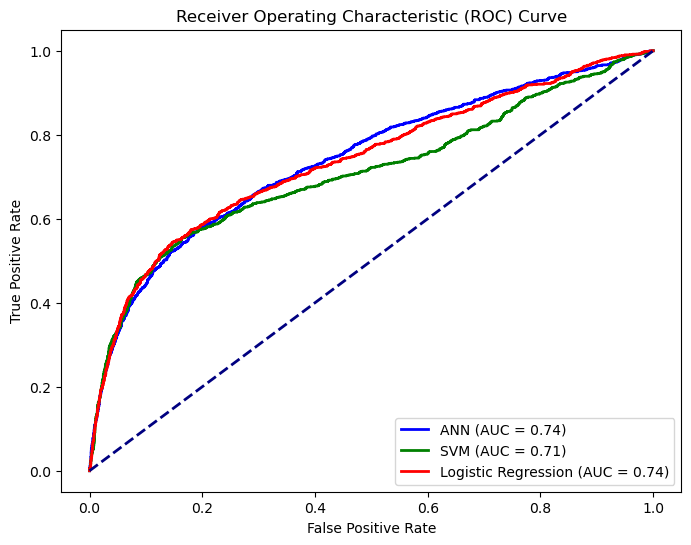

In [31]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train the SVM model (with probability estimation)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

# Train the Stacked (ANN) model
ann_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
ann_model.fit(stacked_train, y_train)

# Get the predicted probabilities
y_pred_prob_ann = ann_model.predict_proba(stacked_test)[:, 1]
y_pred_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_log_reg = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_prob_ann)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_prob_log_reg)

roc_auc_ann = auc(fpr_ann, tpr_ann)
roc_auc_svm = auc(fpr_svm, tpr_svm)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, color='blue', lw=2, label=f'ANN (AUC = {roc_auc_ann:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [33]:
import os
import pickle

# Create the 'model' directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the Random Forest model
with open('model/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save the XGBoost model
with open('model/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save the SVM model
with open('model/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Save the Logistic Regression model
with open('model/log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg_model, f)

# Save the ANN model
with open('model/ann_model.pkl', 'wb') as f:
    pickle.dump(ann_model, f)

print("Models saved successfully!")


Models saved successfully!
